# Training of the LSTM NN

### Variables and functions definition

In [1]:
classes = ["yes", "no", "one", "two", "three", "four"] 
learning_rate = 7*1e-4 
epoch = 100 
batch_size = 64
validation_split = 0.1
dropout = 0.15
recurrent_dropout = 0.15
n_mel = 20 
n_mfcc = 5  


param_grid = {"model__learning_rate": [2*1e-4,5*1e-4,7*1e-4,1e-3],
                "model__dropout": [0.15, 0.35, 0.5],
                "model__recurrent_dropout": [0.15, 0.35, 0.5]}


In [2]:
import os
import pandas as pd
from pickle import load
import numpy as np

def load_and_padding(path, n_mfcc):
    """
    Loads the data from the pickle file and pad the signals to the same length.
    
    Args:
        path: path to the pickle file
        n_mfcc: number of mfcc features
    Returns:
        x: padded mfcc features
        y: labels
        max_length: the length of the longest signal
        X_mask: a mask array to store the length of each padded signal
    """
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)

    max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

In [3]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
def create_train_test(file_path,n_mels,n_mfcc,classes,test_size=0.1,random_state=42): 
    '''
    Creates train and test sets from the data in the file_path

    Args:
        file_path: path to the pickle file
        n_mels: number of mel features
        n_mfcc: number of mfcc features
        classes: list of classes
        test_size: size of the test set
        random_state: random state for the train_test_split function
    Returns:
        X_train: train set
        X_test: test set
        y_train: train labels
        y_test: test labels
        max_length: the length of the longest signal
        num_classes: number of classes
        classes: list of classes
    '''  
    X, y, max_length, X_mask = load_and_padding(file_path, n_mfcc=n_mfcc)
    X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=test_size, random_state=random_state)
    num_classes = len(classes)
    y_train = [classes.index(x) for x in y_train]
    y_train = to_categorical(y_train, num_classes)
    y_test = [classes.index(x) for x in y_test]
    y_test = to_categorical(y_test, num_classes)
    return X_train, X_test, y_train, y_test, max_length, num_classes, classes

In [4]:
from keras.layers import Masking, LSTM, Dense
from keras.models import Sequential
from keras.optimizers import Adam

def create_model(learning_rate, dropout, recurrent_dropout,n_mfcc,max_length,num_classes,n_units=128):
        '''
        Creates the model. The model is a LSTM with 128 units and a softmax layer with num_classes units

        Args:
                learning_rate: learning rate for the Adam optimizer
                dropout: dropout rate for the LSTM layer
                recurrent_dropout: recurrent dropout rate for the LSTM layer
                n_mfcc: number of mfcc features
                max_length: the length of the longest signal
                num_classes: number of classes
                n_units: number of units in the LSTM layer, default

        Returns:
                model: the model
        '''
        model = Sequential()
        model.add(Masking(mask_value=False, input_shape=(n_mfcc, max_length)))
        model.add(LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate), metrics=['accuracy'])
        return model

In [5]:
import audiofile
import scipy.signal as sps
import librosa

def load_from_wav(filePath):
    '''
    Loads the audio from the wav file. The audio is converted to mono and resampled to 20050 Hz

    Args:
        filePath: path to the wav file

    Returns:
        arr: numpy array with the audio
        sr: sample rate
    '''
    audio, sr = librosa.load(filePath)
    arr = np.array(audio, dtype=float)
    return arr, sr


def process_audio(file_path, max_length, n_mels=20, n_mfcc=5):
    '''
    Processes the audio from the wav file. The audio is transformed to a mel spectrogram and then to mfcc

    Args:
        file_path: path to the wav file
        max_length: the length of the longest signal
        n_mels: number of mel features
        n_mfcc: number of mfcc features

    Returns:
        x: numpy array with the processed audio
    '''
    y, sr = load_from_wav(file_path)
    S = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
    mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
    x = np.empty((1, n_mfcc, max_length))
    for i in range(len(mfcc)):
        x[0][i] = np.pad(mfcc[i], (0, max_length - len(mfcc[i])))
    return x


def predict(filePath, classes, model, max_length, n_mels=20, n_mfcc=5):
    '''
    Predicts the class of the audio in the file_path

    Args:
        filePath: path to the wav file
        classes: list of classes
        
    '''
    res = process_audio(filePath, max_length=max_length, n_mels=n_mels, n_mfcc=n_mfcc)
    pred = model.predict(res)
    prediction = classes[np.argmax(pred)]
    return prediction

In [6]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping


callback = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True,verbose=1)

def create_halving_gridsearch(param_grid,model_function=create_model, cv=2, factor=2, n_jobs=-1, verbose=1, validation_split=0.1, epoch=100, batch_size=124, callback=None, min_resources=700, max_resources=1000):
    '''
    Creates the grid search for the hyperparameter tuning

    Args:
        model: the model
        param_grid: the parameters to be tuned
        cv: number of folds for the cross validation
        factor: factor for the halving grid search
        n_jobs: number of jobs to run in parallel
        verbose: verbosity mode
        validation_split: validation split for the training
        epoch: number of epochs for the training
        batch_size: batch size for the training
        callback: callback for the training
        min_resources: minimum number of resources for the training
        max_resources: maximum number of resources for the training

    Returns:
        grid: the grid search 
    '''
    model = KerasClassifier(model=model_function, epochs=epoch, batch_size=batch_size, validation_split=validation_split,callbacks=[callback],loss='categorical_crossentropy',verbose=1)
    # Creating the grid search
    grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid,cv=cv, n_jobs=n_jobs, verbose=verbose, factor=factor, min_resources=min_resources, max_resources=max_resources, scoring='accuracy', random_state=42)
    return grid

# Fine-tuning the hyperparameters

###   Grid search for learning rate, dropout and recurrent dropout


In [ ]:

epoch = 100
batch_size = 124
n_mels_list = [20, 40, 80]
n_mfcc_list = [5, 9, 13, 17]

param_grid = {"model__learning_rate": [2*1e-4, 5*1e-4, 7*1e-4, 1e-3],
              "model__dropout": [0.15, 0.35, 0.5],
              "model__recurrent_dropout": [0.15, 0.35, 0.5]}

# Creating an early stopping callback
callback = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True,verbose=1)
X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/16k_train_20mels_11mfcc.pkl",20,11,classes=classes)

grid = create_halving_gridsearch(param_grid=param_grid, model_function=create_model, cv=2, factor=2, n_jobs=-1, verbose=1, validation_split=0.2, epoch=100, batch_size=124, callback=callback, min_resources=700, max_resources=int(len(y_train)))
grid_result = grid.fit(X_train, y_train)

## Testing with different n_mels and m_fcc

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

callback = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True,verbose=1)

histories = []
test_accuracies = []
for n_mels in n_mels_list:
    for n_mfcc in n_mfcc_list:
        print("starting : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
        X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/validated20mels_5mfcc.pkl",20,5)
        model = create_model(learning_rate, dropout,
                             recurrent_dropout, n_mfcc, max_length, num_classes)
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split, use_multiprocessing=True, callbacks=[callback])
        histories.append(history)
        print("finished : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print("Test accuracy of model with {} recurrent_dropout: {:.4f}".format(recurrent_dropout, test_acc))
        test_accuracies.append(test_acc)


In [ ]:
n_mels = 20
n_mfcc = 5
learning_rate=6*1e-4
epoch = 150
batch_size = 32
validation_split = 0.1
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True,verbose=1)
dropout = 0.15
recurrent_dropout =  0.15
histories = []
test_accuracies = []

X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test(
    "../assets/MFCCs/validated20mels_5mfcc.pkl", 20, 5, classes)


print("starting : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/validated20mels_5mfcc.pkl",20,5)
model = create_model(learning_rate, dropout,
                        recurrent_dropout, n_mfcc, max_length, num_classes)
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split, use_multiprocessing=True, callbacks=[callback])
print("finished : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy of model with {} recurrent_dropout: {:.4f}".format(recurrent_dropout, test_acc))
test_accuracies.append(test_acc)

In [ ]:
n_mels = 20
n_mfcc = 5
learning_rate=6*1e-4
epoch = 150
batch_size = 32
validation_split = 0.1
dropout = 0.15
recurrent_dropout =  0.15

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True,verbose=1)
X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/validated20mels_5mfcc.pkl",20,5)

param_grid = {"model__learning_rate": [5*1e-4,6*1e-4,7*1e-4,1e-3],
                "model__dropout": [0.15, 0.35, 0.5],
                "model__recurrent_dropout": [0.15, 0.35, 0.5]}

# model = KerasClassifier(model=create_model,n_mfcc=n_mfcc,max_length=max_length,num_classes=num_classes, epochs=epoch, batch_size=batch_size, validation_split=validation_split,callbacks=[callback],loss='categorical_crossentropy',verbose=1)

# grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid,cv=2, n_jobs=-1, verbose=1, factor=2, min_resources=700, max_resources=int(len(y_train)*0.8), scoring='accuracy', random_state=42)
# grid_result = grid.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 700
max_resources_: 10008
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 700
Fitting 2 folds for each of 36 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 18
n_resources: 1400
Fitting 2 folds for each of 18 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 9
n_resources: 2800
Fitting 2 folds for each of 9 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 5
n_resources: 5600
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Epoch 1/150
352/352 [==============================] - 34s 52ms/step - loss: 1.6299 - accuracy: 0.3292 - val_loss: 1.4440 - val_accuracy: 0.4333
Epoch 2/150
352/352 [==============================] - 17s 47ms/step - loss: 1.3883 - accuracy: 0.4730 - val_loss: 1.3080 - val_accuracy: 0.5188
Epoch 3/150
352/352 [==============================] - 15s 43ms/step - loss: 1.2359 - accuracy: 0.5449 - va

In [ ]:
grid_result.best_estimator_.score(X_test, y_test)

44/44 [==============================] - 2s 22ms/step


0.7088425593098491

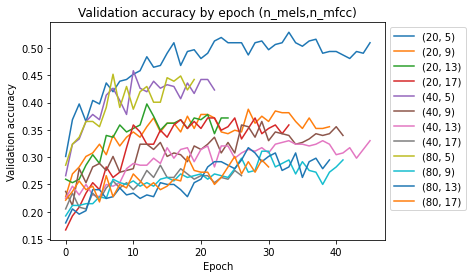

In [ ]:
import matplotlib.pyplot as plt
plt.figure()

labels = []
for n_mels in n_mels_list:
    for n_mfcc in n_mfcc_list:
        labels.append((n_mels,n_mfcc))
for i in range(len(histories)):
    plt.plot(histories[i].history["val_accuracy"])
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Validation accuracy by epoch (n_mels,n_mfcc)")
plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.show()

# Evaluating a prediction

In [ ]:
import audiofile
import scipy.signal as sps
import librosa

def load_from_wav(filePath,sr):
    audio, fs = audiofile.read(filePath)
    dec_factor = fs//sr
    audio = sps.decimate(audio, dec_factor)
    arr = np.array(audio, dtype=float)
    return arr,sr

def process_audio(file_path,max_length=max_length,n_mels=20, n_mfcc=5):
    y, sr = load_from_wav(file_path,44000)
    S = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
    mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
    if len(mfcc.shape)==1:
        mfcc = mfcc[0]
    x = np.empty((1,n_mfcc, max_length))
    for i in range(len(mfcc)):
        x[0][i] = np.pad(mfcc[i], (0, max_length - len(mfcc[i])))
    return x


def predict_result_lstm(filePath,sr,classes, model, max_length=max_length,n_mels=20, n_mfcc=5):
    res = process_audio(filePath, max_length=max_length, n_mels=20, n_mfcc=5)
    pred = model.predict(res)
    prediction = classes[np.argmax(pred)]
    return prediction


In [ ]:
import IPython.display as ipd
path = "./testi (2).wav"
res = process_audio(path,
                    max_length=max_length, n_mels=20, n_mfcc=5)

print(classes)
pred = grid_result.best_estimator_.predict(res)
prediction = classes[np.argmax(pred)]
print(prediction)

ipd.Audio(path)

['no', 'four', 'three', 'yes', 'two', 'one']
1/1 [==============================] - 0s 49ms/step
four


# Training the final model


In [ ]:
from pickle import load
import numpy as np
import tensorflow as tf

classes = ["yes", "no", "one", "two", "three", "four"]


X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/16k_train_20mels_5mfcc.pkl",20,5,classes)

epoch = 100
batch_size = 64
validation_split = 0.1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True,verbose=1)

model = create_model(learning_rate=6.5*1e-4,dropout=0.15,recurrent_dropout=0.15,max_length=max_length,num_classes=num_classes,n_mfcc=5)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 5, 581)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               363520    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 364,294
Trainable params: 364,294
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split,callbacks=[callback],verbose=1)

Epoch 1/100
79/79 [==============================] - 7s 41ms/step - loss: 1.7013 - accuracy: 0.2840 - val_loss: 1.5625 - val_accuracy: 0.3957
Epoch 2/100
79/79 [==============================] - 3s 34ms/step - loss: 1.4834 - accuracy: 0.4245 - val_loss: 1.4504 - val_accuracy: 0.4209
Epoch 3/100
79/79 [==============================] - 3s 34ms/step - loss: 1.3612 - accuracy: 0.4902 - val_loss: 1.4088 - val_accuracy: 0.4406
Epoch 4/100
79/79 [==============================] - 3s 34ms/step - loss: 1.2664 - accuracy: 0.5314 - val_loss: 1.3449 - val_accuracy: 0.4712
Epoch 5/100
79/79 [==============================] - 3s 34ms/step - loss: 1.1760 - accuracy: 0.5797 - val_loss: 1.3012 - val_accuracy: 0.5126
Epoch 6/100
79/79 [==============================] - 3s 34ms/step - loss: 1.0979 - accuracy: 0.6125 - val_loss: 1.2557 - val_accuracy: 0.5396
Epoch 7/100
79/79 [==============================] - 3s 34ms/step - loss: 1.0242 - accuracy: 0.6453 - val_loss: 1.2313 - val_accuracy: 0.5486
Epoch 

In [ ]:
model.save("lstm_20_5_16k_basic.h5")


In [ ]:
model.evaluate(X_test, y_test)


261/261 [==============================] - 2s 7ms/step - loss: 1.1664 - accuracy: 0.5977


[1.166368842124939, 0.5976501703262329]

# Display the confusion matrix

61/61 [==============================] - 1s 8ms/step


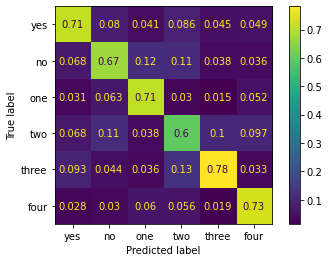

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model

model = load_model("lstm_20_5_16k_augmented")
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction,axis=1)
# y_test = np.argmax(y_test,axis=1)
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

# Predict correct label

In [ ]:
from keras.models import load_model


classes = ["yes", "no", "one", "two", "three", "four"]
n_mel = 20
n_mfcc = 13
max_length = 422


def load_from_wav(filePath,sr):
    audio = AudioSegment.from_wav(filePath)
    audio = audio.set_channels(1).set_frame_rate(sr)
    arr = np.array(audio.get_array_of_samples(), dtype=float)
    return arr,sr

# load_from_wav("./lel.wav", 8000)
# audio, fs = audiofile.read("poto.wav")
# print(fs)

def process_audio(file_path, max_length=422, n_mels=20, n_mfcc=5):
    y, sr = load_from_wav(file_path, 44000)
    S = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
    mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
    # print(mfcc[0])
    # print(mfcc[1])
    # if len(mfcc.shape) == 1:
    #     mfcc = mfcc[0]
    # print(mfcc.shape)
    x = np.empty((1, n_mfcc, max_length))
    for i in range(len(mfcc)):
        x[0][i] = np.pad(mfcc[i], (0, max_length - len(mfcc[i])))
    return x


# def predict_result_lstm(filePath, sr, classes, model, max_length, n_mels=20, n_mfcc=5):
#     res = process_audio(filePath, max_length=max_length, n_mels=20, n_mfcc=5)
#     pred = model.predict(res)
#     prediction = classes[np.argmax(pred)]
#     return prediction


def predict_result_lstm(filePath, classes, model_path, max_length=422, n_mels=20, n_mfcc=5):
    model = load_model(model_path)
    res = process_audio(filePath, max_length, 20, 5)
    print(res.shape)
    pred = model.predict(res)
    prediction = classes[np.argmax(pred)]
    return prediction


print(predict_result_lstm("./sounds/yes_1675445508552.wav",
      classes, "lstm_20_5",422))


# Add my personal database


In [ ]:
import pandas as pd

df = pd.read_csv("./sounds/rahim/rahim.csv", sep=";")
df

,file,sentence
0,one (2).wav,one
1,one (3).wav,one
2,one (4).wav,one
3,one (5).wav,one
4,one (6).wav,one
...,...,...
75,four (17).wav,four
76,four (18).wav,four
77,four (19).wav,four
78,four (20).wav,four


5/5 [==============================] - 0s 10ms/step
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


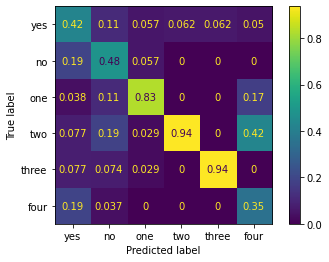

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
from pickle import *
import numpy as np
from lstm_functions import classes


def load_and_padding(path, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)

    # max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, 478))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, 478 - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, 478))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], 478), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, 478, X_mask

def create_train_test(file_path,n_mels,n_mfcc,classes): 
    '''Creates train and test sets from the data in the file_path.'''  
    X, y, max_length, X_mask = load_and_padding(file_path, n_mfcc=n_mfcc)
    num_classes = len(classes)
    y = [classes.index(x) for x in y]
    y = to_categorical(y, num_classes)
    return X, y, max_length, num_classes, classes

X, y, max_length, num_classes, classes = create_train_test("../assets/MFCCs/rahim_mfcc.pkl",20,5,classes)
y_prediction = model.predict(X)
y_prediction = np.argmax(y_prediction,axis=1)
print(np.argmax(y,axis=1))
# y_test = np.argmax(y_test,axis=1)
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

# Testing again with different mels ans mfcc


In [ ]:

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from pickle import *
import numpy as np

def create_train_test(file_path,n_mels,n_mfcc,classes): 
    '''Creates train and test sets from the data in the file_path.'''  
    X, y, max_length, X_mask = load_and_padding(file_path, n_mfcc=n_mfcc)
    X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.6, random_state=42)
    num_classes = len(classes)
    y_train = [classes.index(x) for x in y_train]
    y_train = to_categorical(y_train, num_classes)
    y_test = [classes.index(x) for x in y_test]
    y_test = to_categorical(y_test, num_classes)
    return X_train, X_test, y_train, y_test, max_length, num_classes, classes


def load_and_padding(path, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)

    max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)

n_mels_list = [20]
n_mfcc_list = [5]

for n_mels in n_mels_list:
    for n_mfcc in n_mfcc_list:
        print("starting : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
        X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test(
            "../assets/MFCCs/16k_train_"+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl", 20, 5,classes)
        model = create_model(learning_rate, dropout,
                             recurrent_dropout, n_mfcc, max_length, num_classes)
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
                            validation_split=validation_split, use_multiprocessing=True, callbacks=[callback])
        histories.append(history)
        print("finished : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print("Test accuracy of model with {} recurrent_dropout: {:.4f}".format(
            recurrent_dropout, test_acc))
        test_accuracies.append(test_acc)


NameError: name 'tf' is not defined

# Training model for yes or no 

In [ ]:
# with open("../assets/MFCCs/rahim_mfcc.pkl", "rb") as f:
#     X = load(f)
#     y = load(f)
# print(y)

y = np.array(y)
indices = np.where(y == 'yes')
print(indices)
# X_subsample = X[indices[0]]

X = [X[i] for i in indices[0]]

print(X_subsample)

(array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139], dtype=int64),)
[array([[ 1.35309141e+01,  4.08713369e+01,  5.09511357e+01,
         5.10903557e+01,  5.47650468e+01,  5.74160032e+01,
         5.62925976e+01,  5.09962199e+01,  5.01504103e+01,
         6.68353309e+01,  9.93868296e+01,  1.41297065e+02,
         1.68579762e+02,  1.91532524e+02,  2.12319146e+02,
         2.41317181e+02,  2.67068797e+02,  2.76354709e+02,
         2.72243510e+02,  2.60653821e+02,  2.40493026e+02,
         2.22074335e+02,  2.11823970e+02,  1.91860854e+02,
         1.58916415e+02,  1.55329463e+02,  1.59730115e+02,
         1.52034682e+02,  1.33717545e+02,  9.52197535e+01,
         6.53318933e+01,  3.35182975e+01],
       [ 3.45808434e-01,  2.41459192e-01,  2.00630895e+00,
         3.77565465e+00,  4.13391342e+00,  2.93875731e+00,
         3.92556160e+00,  1.80597749e+00,  1.01388121e+01,
         2.74862028e+01,  2.42654590e+01,  7.03814876e+00,

### ---------------------------------------------------------------------------------------------

### Yes No LSTM Model Train

In [ ]:
!cd

c:\Users\Simon\OneDrive\Documents\FISE3\Semestre 9\Spe-Info2-Big Data\Big Data Project\code\projectBigData\Models\src\lstm


### Load

In [ ]:
import os
import pandas as pd
from pickle import *
import numpy as np

classes = ["yes", "no"]
#16k_train_20mels_5mfcc.pkl
with open("./16k_train_20mels_5mfcc.pkl", "rb") as f:
    X = load(f)
    y = load(f)
print(y)



### X and y with yes and no

In [ ]:
y = np.array(y)
indices_yes = np.where(y == 'yes')
X_yes = [X[i] for i in indices_yes[0]]
y_yes = [y[i] for i in indices_yes[0]]

indices_no = np.where(y == 'no')
X_no = [X[i] for i in indices_no[0]]
y_no = [y[i] for i in indices_no[0]]


In [ ]:
print(len(X_yes))
print(len(y_yes))
print(len(X_no))
print(len(y_no))
#Ok

2495
2495
2373
2373


In [ ]:
X_yes_no = X_yes + X_no
y_yes_no = y_yes + y_no

In [ ]:
print(len(X_yes_no), len(y_yes_no))

4868 4868


### On va modifier la fonction pour le prendre en compte

In [ ]:
def load_and_padding_yes_no(path, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)
    y = np.array(y)
    indices_yes = np.where(y == 'yes')
    X_yes = [X[i] for i in indices_yes[0]]
    y_yes = [y[i] for i in indices_yes[0]]

    indices_no = np.where(y == 'no')
    X_no = [X[i] for i in indices_no[0]]
    y_no = [y[i] for i in indices_no[0]]

    X = X_yes + X_no
    y = y_yes + y_no

    max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

In [ ]:
path = "./16k_train_20mels_5mfcc.pkl"
n_mfcc = 5
X, y, max_length, X_mask = load_and_padding_yes_no(path, n_mfcc)


In [ ]:
print(y)

### Splitting data

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical

# Load the data into a pandas DataFrame
import pandas as pd

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, random_state=42)

In [ ]:
# print(y_train[0])
# print(y_test[0])
# print(classes)

yes
yes


In [ ]:
# classes.index('yes')
# print(to_categorical(classes.index('yes'), num_classes=2))
# len(classes)

[1. 0.]


In [ ]:
num_classes=len(classes)
# y_train = [classes.index(x) for x in y_train]
y_train = to_categorical(y_train, num_classes)
# y_test = [classes.index(x) for x in y_test]
# y_test = to_categorical(y_test, num_classes)

ValueError: invalid literal for int() with base 10: 'yes'

### Training the model with the selected hyperparameters

In [ ]:
n_mels_list = [20, 40, 80]
n_mfcc_list = [5, 9, 13, 17]

learning_rate = 7*1e-4
epoch = 100
batch_size = 64
validation_split = 0.1

dropout = 0.15
recurrent_dropout = 0.15
histories = []
test_accuracies = []